## Introductions

Here is the prompt I used with ChatGPT
- "Can you write a Jupyter notebook which uses fastai to download cat and dog images to train a model to identify dogs and cats?"

ChatGPT responded with "Sure! Below is a Jupyter notebook that uses fastai to download images of cats and dogs and trains a model to identify them."

## ChatGPT Code

ChatGPT generated the code which is contained in the code block below.  It also provided the following set of instructions for how to use the code in a Jupyter notebook:

To use this notebook:

	1.	Make sure you have Jupyter Notebook or JupyterLab installed.
	2.	Save this notebook code into a .ipynb file.
	3.	Run the notebook. It will download the dataset, preprocess the images, train a ResNet34 model, and display the results.

This notebook assumes you have a working Python environment with the fastai library installed. If not, you can install it by running !pip install -Uqq fastai in a Jupyter cell.

This code is different from the manual code I wrote in the following ways:

- 'resnet34' is being used as the pretrained model vs. 'resnet18'.  
- The model is trained on images from the [Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/).  This dataset will improve the accuracy of the model due to the fact the images are of proper dogs and cats (vs. the approach of download the images from the Internet based on a search).
- The model is trained on a larger dataset.

When I ran this code, I ran into a challenge with the coding of the is_cat(x) function.  Please see error I encountered in the comments below long with the changes I asked ChatGPT to make to the function.  Each time I asked ChatGPT to make a change, it generated the full set of code with the respective change to the function.  It also explained the change it made to the function.

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 128MB/s] 


epoch,train_loss,valid_loss,error_rate,time
0,0.160778,0.023478,0.008796,00:38


epoch,train_loss,valid_loss,error_rate,time
0,0.056244,0.032839,0.011502,00:42
1,0.054833,0.025496,0.010149,00:42
2,0.028618,0.009364,0.005413,00:42
3,0.011108,0.005876,0.002706,00:43


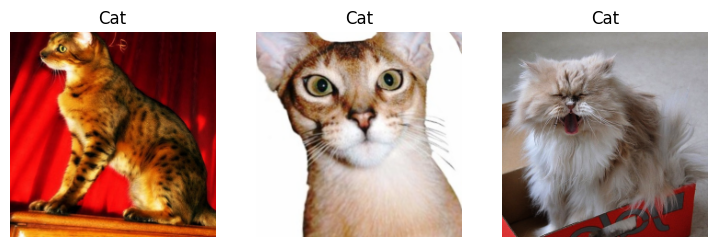

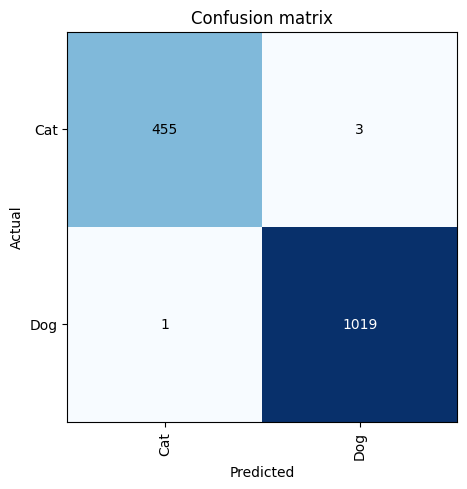

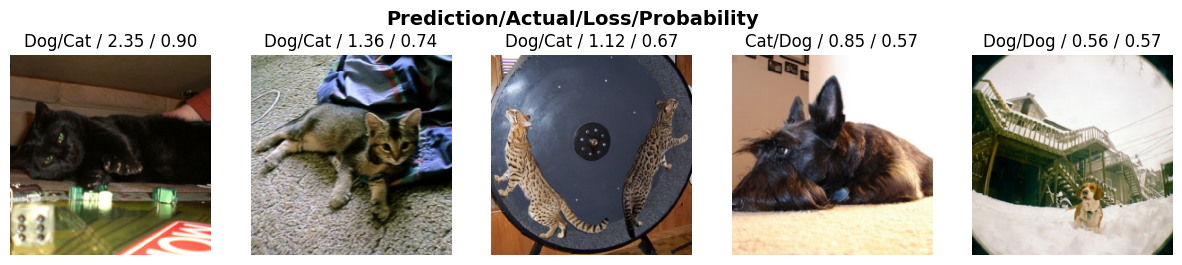

In [1]:
# # %% [markdown]
# # Cats vs Dogs Classifier using fastai
# 
# This notebook demonstrates how to use the fastai library to download images of cats and dogs, and train a model to distinguish between them.

# %%
# Install fastai if not already installed
!pip install -Uqq fastai

# %%
from fastai.vision.all import *
from fastai.data.external import untar_data, URLs

# %%
# Download the dataset
path = untar_data(URLs.PETS)
path

# %%
# The dataset has images and annotations. We only need the images.
(path/'images').ls()

# %%
# The fastai library provides a convenient way to get labels from file names
# DPH: This function generates a TypeError: 'PosixPath' object is not subscriptable
#      This eorror occurs because a Path object is being sent as the input to the function
#      x is a Path object and x[0] is returning "/" for every call
#def is_cat(x): return x[0].isupper()

# When I told ChatGPT about the TypeError with the is_cat(x) function, ChatGPT stated
# the error I am encountering is likely because the is_cat(x) function is being appplied
# to a Path object, not a string.  To fix this, you can convert the Path object to a string
# before indexing. ChatGPT provided the following version of the function.  The challenge 
# with this version is it returns either true or false.  When reading these labels in the 
# confusion matrix, it is hard to remember if true means a dog or a cat.
#def is_cat(x): return x.name[0].isupper()

# I asked ChatGPT to generate a version of this function which retuns "Cat" if the image
# is a cat and "Dog" if the image is a dog.  ChatGPT produced the following version of 
# the function and stated this approach still checks the file name, but returns the 
# respective label as a string instead of a boolean.
def is_cat(x): return "Cat" if x.name[0].isupper() else "Dog"

# %%
# Create a DataBlock
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock), # Data types
    get_items=get_image_files,          # How to get the items
    splitter=RandomSplitter(valid_pct=0.2, seed=42), # Train/validation split
    get_y=is_cat,                       # How to get the labels
    item_tfms=Resize(460),              # Resize images to 460 pixels
    batch_tfms=aug_transforms(size=224, min_scale=0.75) # Data augmentation and resize to 224 pixels
)

# %%
# Load the data
dls = dblock.dataloaders(path/"images")

# %%
# Show some examples
dls.show_batch(nrows=1, ncols=3)

# %%
# Create a learner object and train the model
learn = vision_learner(dls, resnet34, metrics=error_rate)

# %%
# Fine-tune the model
learn.fine_tune(4)

# %%
# Plot confusion matrix to see the results
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

# %%
# Show some misclassified images
interp.plot_top_losses(5, nrows=1)

I used *My Family Pet* dataset to test the accuracy of the model.  This is code I pulled over from my manually coded notebook.

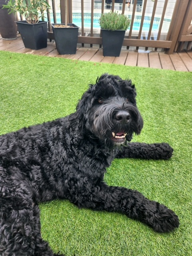

The model thinks Max is a Dog.
Dog Probability: 0.9999
Cat Probability: 0.0001


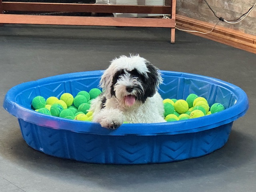

The model thinks Lucy is a Dog.
Dog Probability: 0.9885
Cat Probability: 0.0115


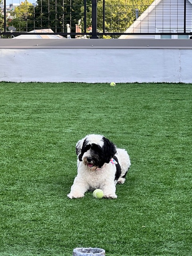

The model thinks Lucy is a Dog.
Dog Probability: 1.0000
Cat Probability: 0.0000


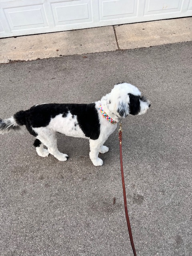

The model thinks Lucy is a Dog.
Dog Probability: 1.0000
Cat Probability: 0.0000


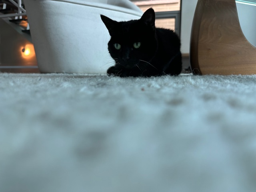

The model things Chica is a Cat.
Dog Probability: 0.0000
Cat Probability: 1.0000


In [2]:
from fastdownload import download_url
from fastai.vision.all import *
from PIL import Image, ImageOps

# Test the model using the image of Max (see My Family Pets dataset)
max_file = "../input/my-family-pets/Max.jpg"
max_image = Image.open(max_file).to_thumb(256, 256)
max_image = ImageOps.exif_transpose(max_image)
result,_,prob = learn.predict(max_image)
display(max_image)
print(f"The model thinks Max is a {result}.")
print(f"Dog Probability: {prob[1]:.4f}")
print(f"Cat Probability: {prob[0]:.4f}")

# Test the model using Lucy's first image (see My Family Pets dataset)
lucy_file = "../input/my-family-pets/Lucy.jpg"
lucy_image = Image.open(lucy_file).to_thumb(256, 256)
lucy_image = ImageOps.exif_transpose(lucy_image)
result,_,prob = learn.predict(lucy_image)
display(lucy_image)
print(f"The model thinks Lucy is a {result}.")
print(f"Dog Probability: {prob[1]:.4f}")
print(f"Cat Probability: {prob[0]:.4f}")

# Test the model using Lucy's second image (see My Family Pets dataset)
lucy_file2 = "../input/my-family-pets/Lucy_2.jpg"
lucy_image2 = Image.open(lucy_file2).to_thumb(256, 256)
lucy_image2 = ImageOps.exif_transpose(lucy_image2)
result,_,prob = learn.predict(lucy_image2)
display(lucy_image2)
print(f"The model thinks Lucy is a {result}.")
print(f"Dog Probability: {prob[1]:.4f}")
print(f"Cat Probability: {prob[0]:.4f}")

# Test the model using Lucy's third image (see My Family Pets dataset)
lucy_file3 = "../input/my-family-pets/Lucy_3.jpg"
lucy_image3 = Image.open(lucy_file3).to_thumb(256, 256)
lucy_image3 = ImageOps.exif_transpose(lucy_image3)
result,_,prob = learn.predict(lucy_image3)
display(lucy_image3)
print(f"The model thinks Lucy is a {result}.")
print(f"Dog Probability: {prob[1]:.4f}")
print(f"Cat Probability: {prob[0]:.4f}")

# Test the model using Chica's image (see My Family Pets dataset)
chica_file = '../input/my-family-pets/Chica.jpg'
chica_image = Image.open(chica_file).to_thumb(256, 256)
chica_image = ImageOps.exif_transpose(chica_image)
result,_,prob = learn.predict(PILImage.create(chica_image))
display(chica_image)
print(f"The model things Chica is a {result}.")
print(f"Dog Probability: {prob[1]:.4f}")
print(f"Cat Probability: {prob[0]:.4f}")